# Trajectory Analysis

In [3]:
from postrunplotter import *

In [9]:
folder_paths = [
    'data/box_09-10-23/box-with-rot_2min_09-10-23',
    'data/box_09-10-23/box-no-rot_2min_09-10-23',
    'data/box_09-10-23/box-no-rot_5m_09-10-23',
    'data/box_09-10-23/box-with-rot_5m_09-10-23',
]
folder_path = folder_paths[0]

In [10]:
import pandas as pd
from trajectopy_core.trajectory import Trajectory
from trajectopy_core.plotting.trajectory_plot import plot_trajectories
from matplotlib import pyplot as plt

def rotate_sensor(df, rotation=[0, 0, 0]):

    df_rots = R.from_quat(df[['qx', 'qy', 'qz', 'qw']])

    rot = R.from_euler('xyz', rotation, degrees=True)

    df_rots = rot * df_rots

    df[['qx', 'qy', 'qz', 'qw']] = df_rots.as_quat()

    return df

def df_to_traj(df, name):
    xyz = df[['x', 'y', 'z']].values
    quat = df[['qx', 'qy', 'qz', 'qw']].values
    tstamps = df['time'].values
    traj = Trajectory.from_numpy(xyz,quat,tstamps)
    traj.name = name

    tstamp_index = np.unique(traj.tstamps, return_index=True)[1]
    traj.apply_index(tstamp_index) 

    return traj

In [ ]:
mars_traj_list = []
opti_traj_list = []

for folder_path in folder_paths:
    mars = read_out(os.path.join(folder_path, 'Output.bag'))
    ts, opti, _ = get_files(folder_path)
    opti = cam_to_ned(opti)
    mars = mars_to_ned(mars)
    add_vector(mars, offset_vector=np.array([0.0439, -0.0224, -0.01365]))

    opti = rotate_sensor(opti, [0, 0, 360 - 129.9751])


    mars_traj = df_to_traj(mars, 'mars')
    opti_traj = df_to_traj(opti, 'opti')

    mars_traj, opti_traj = mars_traj.same_sampling(opti_traj)

    mars_traj_list.append(mars_traj)
    opti_traj_list.append(opti_traj)

    print(mars_traj)

    plot_trajectories([mars_traj, opti_traj], dim=2)
    plt.show()

In [ ]:
mars = read_out(os.path.join(folder_path, 'Output.bag'))
#add_vector(mars, offset_vector = np.array([0.0439, 0.0224, 0.01365]))

ts, opti, _ = get_files(folder_path)
opti = cam_to_ned(opti)
mars = mars_to_ned(mars)
add_vector(mars, offset_vector = np.array([0.0439, -0.0224, -0.01365]))

#mars2 = quaternions_to_euler_angles(mars)
##print(f"Mars:\n{mars2[['ex', 'ey', 'ez']].head(300)}")
opti = rotate_sensor(opti, [0, 0, 360 - 129.9751])
#opti = rotate_sensor(opti, [0, 5, 0])
#opti = rotate_sensor(opti, [0, 0, 100])

#exit(1)
mars_traj = df_to_traj(mars, 'mars')
opti_traj = df_to_traj(opti, 'opti')

mars_traj, opti_traj  = mars_traj.same_sampling(opti_traj)
print(mars_traj)

plot_trajectories([mars_traj, opti_traj], dim=2)
plt.show()

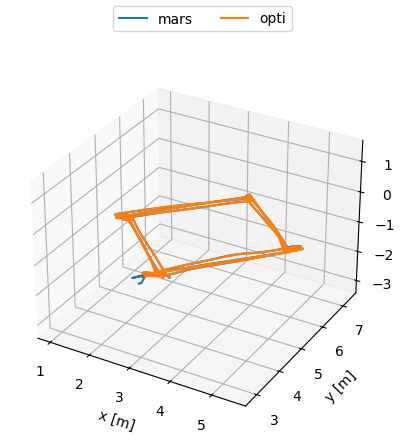

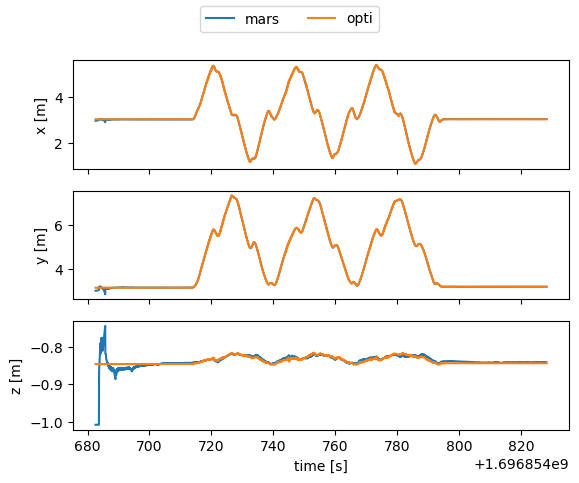

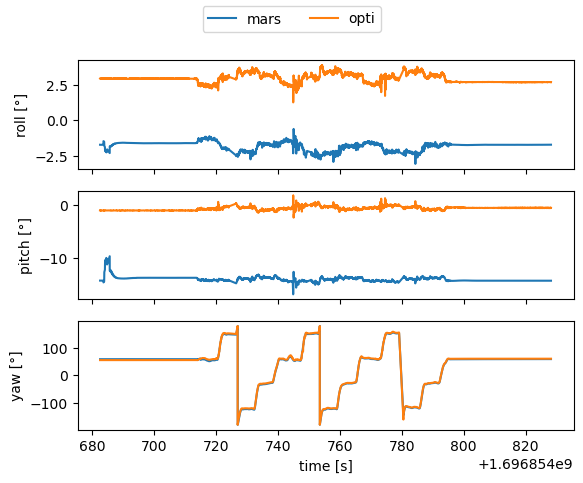

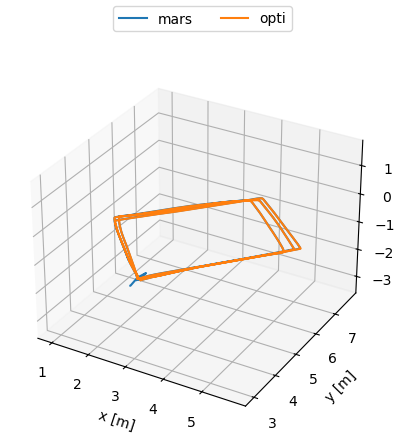

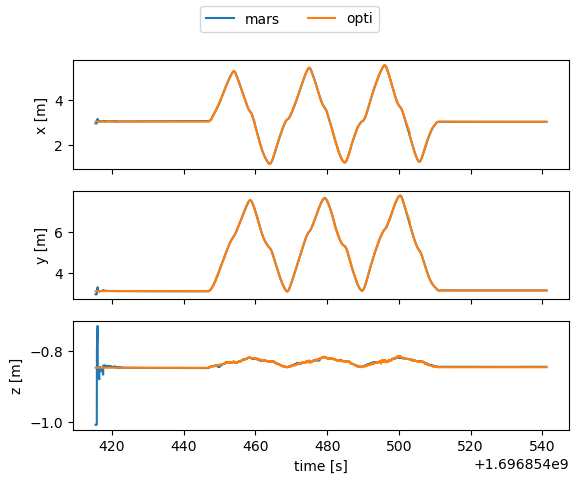

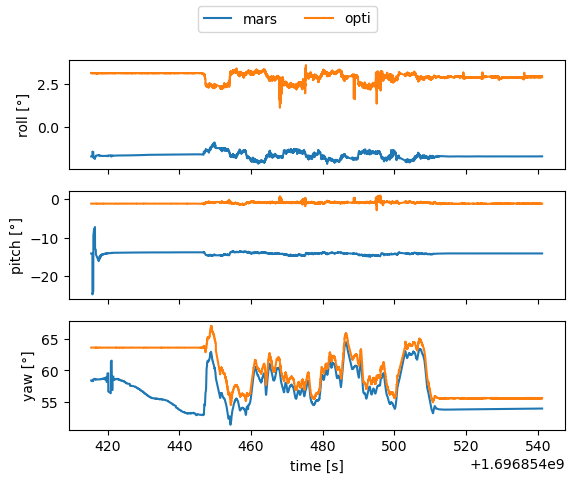

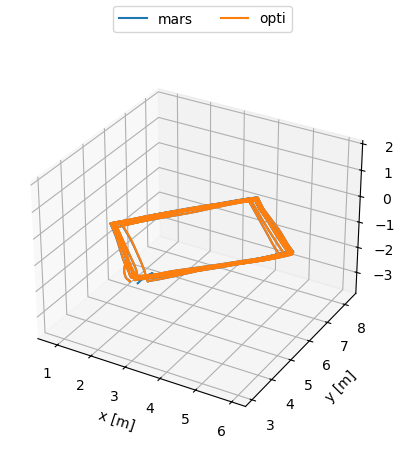

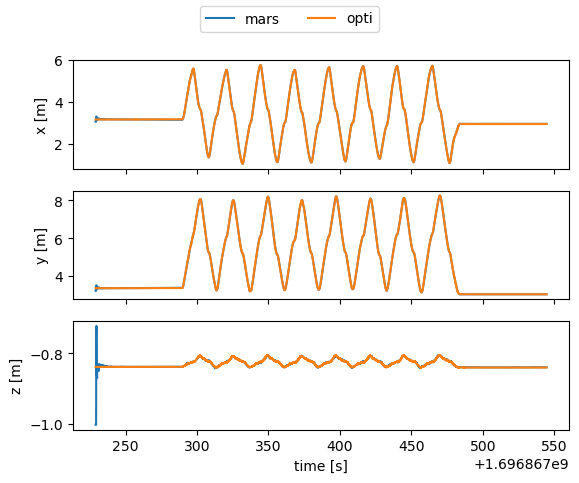

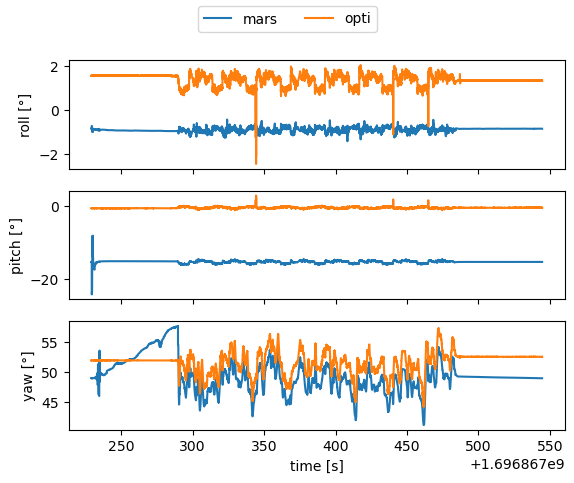

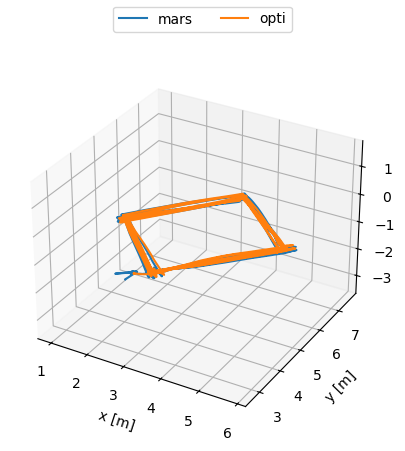

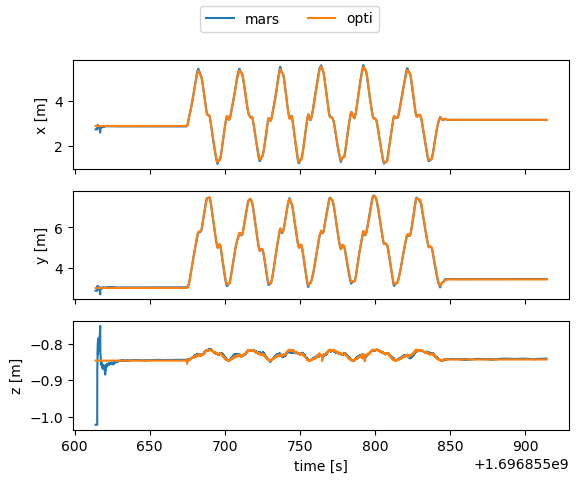

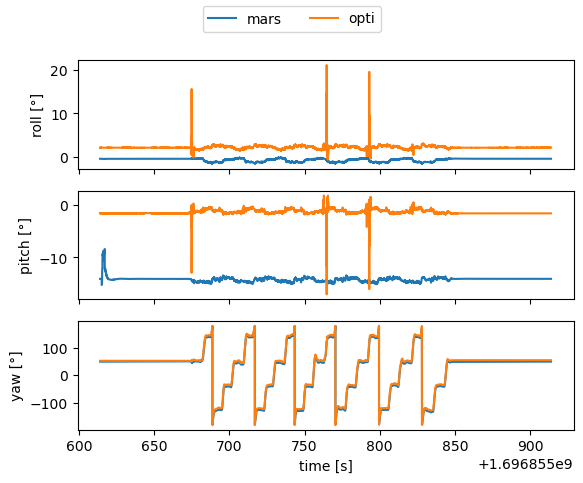

In [21]:
from trajectopy_core.settings.alignment_settings import AlignmentSettings
from trajectopy_core.settings.matching_settings import MatchingMethod, MatchingSettings
from trajectopy_core.alignment.actions import align_trajectories

align_params = {
        "estimation_of": {
            "helmert": True,
            #"leverarm": False,
            #"time_shift": True,
            'scale': False,
            #'sensor_rotation': True
    }
}

def align(groundTruth, estimate):

    alignment = align_trajectories(
        traj_from=estimate,
        traj_to=groundTruth,
        alignment_settings=AlignmentSettings.from_config_dict(align_params),
        matching_settings=MatchingSettings(method=MatchingMethod.INTERPOLATION),
    )
#print(alignment)
#print(alignment.position_parameters)
#print(alignment.rotation_parameters)
#print(alignment.estimation_of)
    estimate.apply_alignment(alignment)
    return alignment

#alignment = align(opti_traj,mars_traj)
#plot_trajectories([mars_traj, opti_traj], dim=3)
#plt.show()
for mars_traj, opti_traj in zip(mars_traj_list, opti_traj_list):
    alignment = align(opti_traj, mars_traj)
    plot_trajectories([mars_traj, opti_traj], dim=3)
    plt.show()